# Exploring CausalML for causal inference

Quick exploration into the CausalML library. I will apply it to the same simple scenarios previously [CausalInference/causal_regression_coefficient.ipynb](CausalInference/causal_regression_coefficient.ipynb), where we have a single confounder or a single collider.

Outline:
*   Generate random linear data
*   Estimate treatment effects with DoWhy
*   Repeat in the presence on confounder variables
*   Repeat in the presence on collider variables

In [ ]:
%pip install dowhy causalml doubleml tqdm scikit-learn statsmodels

In [92]:
import pandas as pd
import numpy as np
import dowhy
from IPython.display import Image, display


## Simple data generating case

For the first simple case we have no confounding variables and no collider variables.

In [111]:
def generate_data(seed: int = None):
    n_samples = 1000
    n_features = 3
    treatment_binary = True

    rand = np.random.default_rng(seed)
    x = rand.normal(loc=rand.normal(size=n_features), size=(n_samples, n_features))
    if treatment_binary:
        t = rand.binomial(n=1, p=0.5, size=(n_samples, 1))
    else:
        t = rand.normal(size=(n_samples, 1))
    bias = rand.normal()
    weights = rand.normal(size=(n_features + 1, 1))
    y = bias + np.dot(np.concatenate([t, x], axis=1), weights) + rand.normal()

    x_cols = [f"x_{idx+1}" for idx in range(3)]
    t_col = "t"
    y_col = "y"
    df = pd.DataFrame(x, columns=x_cols)
    df[t_col] = t
    df[y_col] = y
    df = df[[y_col, t_col] + x_cols]
    
    data_config = {
        "x_cols": x_cols,
        "t_col": t_col,
        "y_col": y_col,
        "n_samples": n_samples,
        "n_features": n_features,
        "treatment_binary": treatment_binary,
    }

    return df, bias, weights, data_config


df, bias, weights, data_config = generate_data(1)

print(bias, weights)


0.32159556492393304 [[ 0.6650024 ]
 [-1.93805094]
 [ 1.30563042]
 [ 1.34233201]]


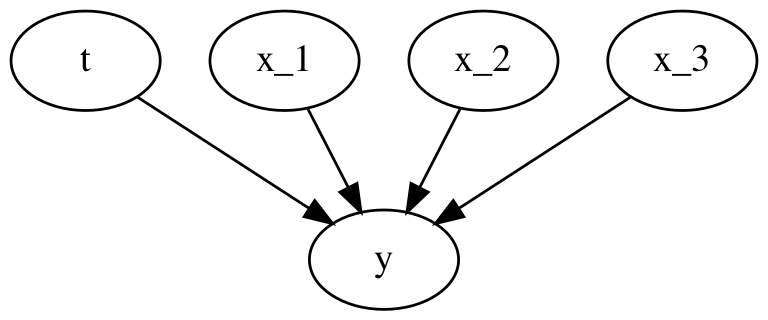

In [94]:
causal_graph = """
digraph {
    t -> y;
    x_1 -> y;
    x_2 -> y;
    x_3 -> y;
}
"""

causal_model = dowhy.CausalModel(
    data=df, graph=causal_graph.replace("\n", " "), treatment=t_col, outcome=y_col
)
causal_model.view_model()
display(Image(filename="causal_model.png"))


Fitting a linear regression model will let us estimate the coefficients and therefore treatment effect.
We can do this adding one feature at a time to see how the extra features change the coefficients of the treatment effect.

In [95]:
# fit linear regression with adding a feature at a time
import sklearn.linear_model

fitted_bias = []
fitted_coef = []
for idx in range(data_config['n_features'] + 1):
    model = sklearn.linear_model.LinearRegression()
    model.fit(df[[data_config['t_col']] + data_config['x_cols'][:idx]], df[data_config['y_col']])
    fitted_bias.append(model.intercept_)
    fitted_coef.append(model.coef_)

print("\n")
print("True weights:")
print(bias, weights)


df_coef = pd.DataFrame(fitted_coef, columns=[data_config['t_col']] + data_config['x_cols'])
df_coef["bias"] = fitted_bias
df_coef




True weights:
0.32159556492393304 [[ 0.6650024 ]
 [-1.93805094]
 [ 1.30563042]
 [ 1.34233201]]


,t,x_1,x_2,x_3,bias
0,1.195088,NaN,NaN,NaN,2.696746
1,0.992753,-1.832928,NaN,NaN,3.464477
2,0.778484,-1.888811,1.224334,NaN,2.551327
3,0.665002,-1.938051,1.305630,1.342332,2.184879


## Propensity based models

Propensity matching

Inverse propensity weights

## Meta learners

The methods here are mostly explained with the great book [https://matheusfacure.github.io/python-causality-handbook/21-Meta-Learners.html](https://matheusfacure.github.io/python-causality-handbook/21-Meta-Learners.html).

### S-Learners

Here we train a standard model and make predictions with and without the treatment variable set. The difference gives us the treatment effect.

In [96]:
import causalml.inference.meta

lr = causalml.inference.meta.LRSRegressor()
te, lb, ub = lr.estimate_ate(df[data_config['x_cols']], df[data_config['t_col']], df[data_config['y_col']])
print('Average Treatment Effect (Linear Regression): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))


Average Treatment Effect (Linear Regression): 0.67 (0.67, 0.67)


In [97]:
# s learner with Linear regression base model
sl = causalml.inference.meta.BaseSRegressor(learner=sklearn.linear_model.LinearRegression())
te =  sl.estimate_ate(X=df[data_config['x_cols']], treatment=df[data_config['t_col']], y=df[data_config['y_col']])#p=e, 
te

array([0.6650024])

Running with an XGBoost model gives a reasonable but biased estimate.

In [98]:
# s learner with XGB base model
from xgboost import XGBRegressor
sl = causalml.inference.meta.BaseSRegressor(learner=XGBRegressor(random_state=0))
te =  sl.estimate_ate(X=df[data_config['x_cols']], treatment=df[data_config['t_col']], y=df[data_config['y_col']])#p=e, 
te

array([0.44879038])

### T/R/S Learners
With linear regression and XGboost


In [99]:
xl = causalml.inference.meta.BaseXRegressor(learner=sklearn.linear_model.LinearRegression())
te, lb, ub = xl.estimate_ate(df[data_config['x_cols']], df[data_config['t_col']], df[data_config['y_col']])
print('Average Treatment Effect (BaseXRegressor using XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

rl = causalml.inference.meta.BaseRRegressor(learner=sklearn.linear_model.LinearRegression())
te, lb, ub =  rl.estimate_ate(df[data_config['x_cols']], df[data_config['t_col']], df[data_config['y_col']])
print('Average Treatment Effect (BaseRRegressor using XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

sl = causalml.inference.meta.BaseSRegressor(learner=sklearn.linear_model.LinearRegression())
te =  sl.estimate_ate(df[data_config['x_cols']], df[data_config['t_col']], df[data_config['y_col']])
print('Average Treatment Effect (BaseSRegressor using XGBoost): {:.2f}'.format(te[0]))


Average Treatment Effect (BaseXRegressor using XGBoost): 0.67 (0.67, 0.67)
Average Treatment Effect (BaseRRegressor using XGBoost): 0.67 (0.67, 0.67)
Average Treatment Effect (BaseSRegressor using XGBoost): 0.67



Rerunning the XGBoost base model in an X learner and R learner model gives a much closer result than the biased S learner.

In [100]:
xl = causalml.inference.meta.BaseXRegressor(learner=XGBRegressor(random_state=42))
te, lb, ub = xl.estimate_ate(df[data_config['x_cols']], df[data_config['t_col']], df[data_config['y_col']])
print('Average Treatment Effect (BaseXRegressor using XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

rl = causalml.inference.meta.BaseRRegressor(learner=XGBRegressor(random_state=42))
te, lb, ub =  rl.estimate_ate(df[data_config['x_cols']], df[data_config['t_col']], df[data_config['y_col']])
print('Average Treatment Effect (BaseRRegressor using XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

sl = causalml.inference.meta.BaseSRegressor(learner=XGBRegressor(random_state=42))
te =  sl.estimate_ate(df[data_config['x_cols']], df[data_config['t_col']], df[data_config['y_col']])
print('Average Treatment Effect (BaseSRegressor using XGBoost): {:.2f}'.format(te[0]))


Average Treatment Effect (BaseXRegressor using XGBoost): 0.66 (0.64, 0.67)


/Users/Rich/Developer/miniconda3/envs/causal_inf_env/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/Rich/Developer/miniconda3/envs/causal_inf_env/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/Rich/Developer/miniconda3/envs/causal_inf_env/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/Rich/Developer/miniconda3/envs/causal_inf_env/lib/python3.10/site-packages/xgboost/compat.

Average Treatment Effect (BaseRRegressor using XGBoost): 0.71 (0.71, 0.71)
Average Treatment Effect (BaseSRegressor using XGBoost): 0.45


## Others

### Doubly robust learners


In [122]:
# doubly robust learner
dl = causalml.inference.meta.BaseDRRegressor(learner=XGBRegressor())
te, lb, ub = dl.estimate_ate(
    df[data_config["x_cols"]], df[data_config["t_col"]], df[data_config["y_col"]]
)
print(
    "Average Treatment Effect (BaseRRegressor using XGBoost): {:.2f} ({:.2f}, {:.2f})".format(
        te[0], lb[0], ub[0]
    )
)


Average Treatment Effect (BaseRRegressor using XGBoost): 0.67 (0.61, 0.73)


### Double ML
[https://matheusfacure.github.io/python-causality-handbook/22-Debiased-Orthogonal-Machine-Learning.html](https://matheusfacure.github.io/python-causality-handbook/22-Debiased-Orthogonal-Machine-Learning.html).

Using the [doubleml](https://docs.doubleml.org/stable/index.html) package to train the models.

The Causal ML models are using logistic regression for the treatmemt propensity models. Here we are using XGBoost.

In [142]:
import doubleml as dml

# create dataset
data_dml_base = dml.DoubleMLData(
    df,
    y_col=data_config["y_col"],
    d_cols=data_config["t_col"],
    x_cols=data_config["x_cols"],
)
print(data_dml_base)


================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): ['t']
Covariates: ['x_1', 'x_2', 'x_3']
Instrument variable(s): None
No. Observations: 1000

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 5 entries, y to x_3
dtypes: float64(4), int64(1)
memory usage: 39.2 KB



In [143]:
# train model with XGB regressor as the outcome model and XGB classifier as the treatment model.
import sklearn.linear_model
dml_plr_boost = dml.DoubleMLPLR(
    data_dml_base, ml_g=XGBRegressor(), ml_m=sklearn.linear_model.LogisticRegressionCV(), n_folds=3
)
# dml_plr_boost = dml.DoubleMLPLR(
#     data_dml_base, ml_g=XGBRegressor(), ml_m=XGBClassifier(), n_folds=3
# )
dml_plr_boost.fit(store_predictions=True)
boost_summary = dml_plr_boost.summary
boost_summary


,coef,std err,t,P>|t|,2.5 %,97.5 %
t,-0.071172,0.00513,-13.873011,9.231801e-44,-0.081227,-0.061117


## Multiple trials
Repeating over many samples to confirm our results

In [160]:
import tqdm
try:
    est_weights.keys()
except NameError:
    est_weights = {
        'true_weight':[],
        's_lin_learner':[],
        's_learner':[],
        'x_learner':[],
        'r_learner':[],
        'dr_learner':[],
        'doubleml_learner':[],
    }
for n in tqdm.trange(30):
    df, bias, weights, data_config = generate_data(len(est_weights['true_weight'])+1)
    est_weights['true_weight'].append(weights[0][0])

    sl = causalml.inference.meta.BaseSRegressor(learner=sklearn.linear_model.LinearRegression())
    te =  sl.estimate_ate(df[data_config['x_cols']], df[data_config['t_col']], df[data_config['y_col']])
    est_weights['s_lin_learner'].append(te[0])

    xl = causalml.inference.meta.BaseXRegressor(learner=XGBRegressor())
    te, lb, ub = xl.estimate_ate(df[data_config['x_cols']], df[data_config['t_col']], df[data_config['y_col']])
    est_weights['x_learner'].append(te[0])

    rl = causalml.inference.meta.BaseRRegressor(learner=XGBRegressor())
    te, lb, ub =  rl.estimate_ate(df[data_config['x_cols']], df[data_config['t_col']], df[data_config['y_col']])
    est_weights['r_learner'].append(te[0])
    
    sl = causalml.inference.meta.BaseSRegressor(learner=XGBRegressor())
    te =  sl.estimate_ate(df[data_config['x_cols']], df[data_config['t_col']], df[data_config['y_col']])
    est_weights['s_learner'].append(te[0])

    dl = causalml.inference.meta.BaseDRRegressor(learner=XGBRegressor())
    te, lb, ub =  dl.estimate_ate(df[data_config['x_cols']], df[data_config['t_col']], df[data_config['y_col']])
    est_weights['dr_learner'].append(te[0])


    # double ML
    data_dml_base = dml.DoubleMLData(
        df,
        y_col=data_config["y_col"],
        d_cols=data_config["t_col"],
        x_cols=data_config["x_cols"],
    )
    boost = XGBRegressor()
    boost_class = sklearn.linear_model.LogisticRegressionCV()
    dml_plr_boost = dml.DoubleMLPLR(data_dml_base,
                                    ml_g = boost,
                                    ml_m = boost_class,
                                    n_folds = 3)
    dml_plr_boost.fit(store_predictions=True)
    boost_summary = dml_plr_boost.summary
    est_weights['doubleml_learner'].append(boost_summary['coef'][0])


100%|██████████| 30/30 [02:28<00:00,  4.95s/it]


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

,true_weight,s_lin_learner,s_learner,x_learner,r_learner,dr_learner,doubleml_learner
0,0.665002,0.665002,0.448790,0.659014,0.683244,0.695988,0.655042
1,-1.977871,-1.977871,-1.942159,-1.971452,-2.030323,-1.961631,-1.998437
2,1.195824,1.195824,1.128756,1.202924,1.239278,1.186153,1.178039
3,0.168356,0.168356,0.088775,0.160638,0.190905,0.174108,0.182107
4,-1.368478,-1.368478,-1.176251,-1.348204,-1.429262,-1.334922,-1.447656
5,-1.719575,-1.719575,-1.599841,-1.716345,-1.754524,-1.709912,-1.704141
6,0.892273,0.892273,0.866274,0.898153,0.916578,0.882315,0.852040
7,0.984419,0.984419,0.955639,0.981617,0.999867,0.975835,0.972282
8,-0.915350,-0.915350,-0.841059,-0.909178,-0.928994,-0.908455,-0.920296
9,-1.039698,-1.039698,-0.964393,-1.047895,-1.068737,-1.083698,-1.052647


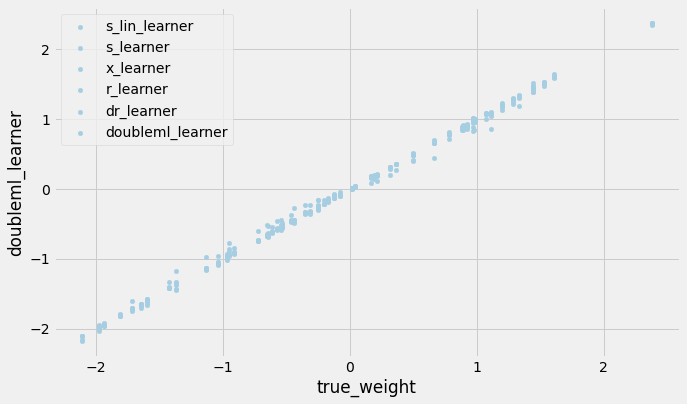

In [161]:
import matplotlib.pyplot as plt
df_trials = pd.DataFrame(est_weights)
# df_trials.plot(kind='scatter', x='true_weight', y=['s_learner','x_learner','r_learner'])
fig, ax = plt.subplots(figsize=(10,6))
for col in df_trials.drop(columns='true_weight').columns:
    df_trials.plot(kind='scatter', x='true_weight', y=col, label=col, ax=ax)
df_trials

In [204]:
diff = df_trials.drop(columns="true_weight").subtract(
    df_trials["true_weight"], axis=0
)
df_results = pd.concat([diff.abs().mean().rename('abs_mean'), diff.std().rename('std')], axis=1)
df_results

,abs_mean,std
s_lin_learner,3.412201e-16,5.091920e-16
s_learner,7.770330e-02,9.579229e-02
x_learner,7.556779e-03,1.041789e-02
r_learner,2.437020e-02,3.025393e-02
dr_learner,1.246201e-02,1.657847e-02
doubleml_learner,2.021034e-02,2.701669e-02


Let's plot the distribution of the error in the treatment effects.

<AxesSubplot:>

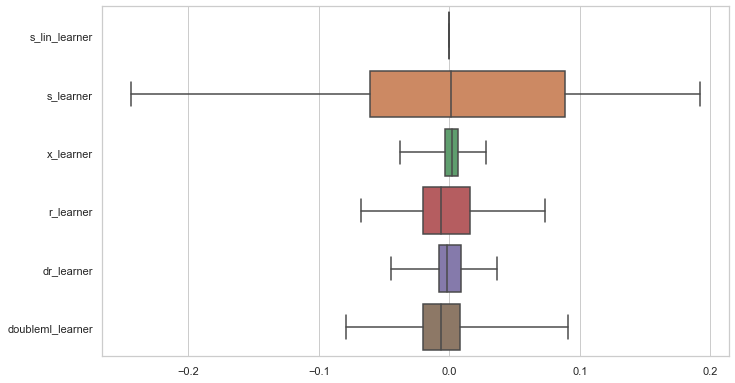

In [201]:
# Plot the orbital period with horizontal boxes
import seaborn as sns

sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=diff, orient="h", whis=[0, 100], ax=ax)


S-learner has a wider distribution than the other meta learners.


## more datasets

In [206]:
import causalml.dataset
dataset = causalml.dataset.synthetic_data(mode=1, n=1000, p=5, sigma=1.0, adj=0.0)
dataset


            # - y ((n,)-array): outcome variable.
            # - X ((n,p)-ndarray): independent variables.
            # - w ((n,)-array): treatment flag with value 0 or 1.
            # - tau ((n,)-array): individual treatment effect.
            # - b ((n,)-array): expected outcome.
            # - e ((n,)-array): propensity of receiving treatment.

(array([ 9.46827445e-01,  3.50947602e-01,  6.16632146e-01, -7.51332697e-01,
         2.39300115e+00,  3.67919889e+00,  4.20274368e-01,  3.37106713e+00,
         2.61278869e+00,  1.00998958e+00,  6.37663673e-01,  9.88437193e-01,
         1.05439992e+00,  1.92180360e+00,  1.87191602e+00,  2.58325689e+00,
         2.58605486e+00,  1.53599504e+00,  2.38676467e+00,  1.27765619e+00,
         1.07974386e+00,  3.27123882e+00,  1.01164261e+00,  6.59124078e-01,
         1.12992546e+00,  1.76689123e+00,  1.09746839e+00,  2.96462893e+00,
         3.56518553e+00,  9.33735899e-01,  2.03462660e+00,  3.11263522e+00,
        -1.69062990e+00,  2.07366231e-01,  1.17458916e+00,  1.03497370e+00,
        -6.31294527e-01,  8.02994647e-01,  8.91104409e-01,  1.21860643e+00,
         2.90709380e+00,  5.64928197e-01,  1.38927397e+00,  1.40548560e+00,
        -4.23422066e-01,  2.62175028e+00,  1.52657629e+00,  2.04836663e+00,
         3.50556846e-01,  9.84140532e-01, -1.36008052e-01,  1.10772156e+00,
         2.4

In [207]:
y, X, treatment, tau, b, e = causalml.dataset.synthetic_data(mode=1, n=10000, p=8, sigma=1.0)
treatment

array([1, 1, 1, ..., 1, 0, 1])

In [ ]:
if 0:
    X = np.random.uniform(size=n * p).reshape((n, -1))
    b = (
        np.sin(np.pi * X[:, 0] * X[:, 1])
        + 2 * (X[:, 2] - 0.5) ** 2
        + X[:, 3]
        + 0.5 * X[:, 4]
    )
    eta = 0.1
    e = np.maximum(
        np.repeat(eta, n),
        np.minimum(np.sin(np.pi * X[:, 0] * X[:, 1]), np.repeat(1 - eta, n)),
    )
    e = expit(logit(e) - adj)
    tau = (X[:, 0] + X[:, 1]) / 2

    w = np.random.binomial(1, e, size=n)
    y = b + (w - 0.5) * tau + sigma * np.random.normal(size=n)

In [214]:
y

array([0.30014699, 2.14851901, 2.89897711, ..., 1.39785278, 0.9317096 ,
       1.69904454])

In [217]:
np.min(e)

## Conclusion

